In [ ]:
!pip install mendelai-brat-parser

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

nltk.download('universal_tagset')

  Created wheel for mendelai-brat-parser: filename=mendelai_brat_parser-0.0.8-py3-none-any.whl size=4847 sha256=1e3311906841c53313f15c7007b6b72caa16cb548d4223acf5b2ac6443c061d3
  Stored in directory: /root/.cache/pip/wheels/63/ad/4c/8bf3f686c12a241375b9e8a1f51016ed192144808b278831dd
Successfully built mendelai-brat-parser
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import regex as re
from collections import Counter
import math

from google.colab import files
import zipfile
import glob

from brat_parser import get_entities_relations_attributes_groups

from nltk.tag import pos_tag, map_tag

from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from brat_parser import get_entities_relations_attributes_groups

import gensim
import gensim.downloader as api
from gensim.models import Word2Vec

from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Neural network imports.
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input, Dropout
from keras.layers import TimeDistributed
from keras.layers import Concatenate
from keras.layers import LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model, Input

In [ ]:
# Import the BOW of the bigrams of the sentences.
print('\nImport all_sentence_claim_premise_bigram_POS.csv\n')
upload = files.upload()


Import all_sentence_claim_premise_bigram_POS.csv



Saving all_sentences_claim_premise_bigram_POS.csv to all_sentences_claim_premise_bigram_POS.csv


In [ ]:
# Import the BOW of the bigrams of the sentences.
print('\nImport Debater_all_sentence_claim_premise_bigram_POS.csv\n')
upload = files.upload()


Import Debater_all_sentence_claim_premise_bigram_POS.csv



Saving Debater_all_sentence_claim_premise_bigram_POS.csv to Debater_all_sentence_claim_premise_bigram_POS.csv


In [ ]:
# Import the Stab and Gurevych dataset (2017 version).

uploaded = files.upload()

Saving ArgumentAnnotatedEssays-2.0.zip to ArgumentAnnotatedEssays-2.0.zip


In [ ]:
# Import the premise positions in the articles for the IBM Debater dataset (premise-positions.txt).

uploaded = files.upload()

# Import the claims positions in the articles for the IBM Debater dataset (claim-positions.txt).

uploaded = files.upload()

Saving claim-positions.txt to claim-positions.txt


Saving premise-positions.txt to premise-positions.txt


In [ ]:
# Import the IBM Debater dataset (2015 version).

uploaded = files.upload()

Saving IBM_Debater_(R)_CE-EMNLP-2015.v3.zip to IBM_Debater_(R)_CE-EMNLP-2015.v3.zip


# **Stab and Gurevych Dataset**

In [ ]:
# Function to extract zip file.
# Takes in input the path to the zip file (path_zip) and the one to store the destination directory (path_destination).

def extract_zip(path_zip,path_destination):
  with zipfile.ZipFile(path_zip, 'r') as zip_ref:
    zip_ref.extractall(path_destination)


In [ ]:
# Extract zip file (two zip files one inside the other).

extract_zip('ArgumentAnnotatedEssays-2.0.zip','ArgumentAnnotatedEssays-2.0')

extract_zip('ArgumentAnnotatedEssays-2.0/ArgumentAnnotatedEssays-2.0/brat-project-final.zip','ArgumentAnnotatedEssays')

## **Create and visualize the required Dataframe**

In [ ]:
# Extract the list of text files of the essays in the dataset.
txt_files = sorted(glob.glob("ArgumentAnnotatedEssays/brat-project-final/essay*.txt"))

# Extract the list of text files of the essays in the dataset.
ann_files = sorted(glob.glob("ArgumentAnnotatedEssays/brat-project-final/essay*.ann"))

In [ ]:
# List of text files of the essays.
txt_files[0:5]

['ArgumentAnnotatedEssays/brat-project-final/essay001.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay002.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay003.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay004.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay005.txt']

In [ ]:
# List of the annotated files of the essays.
ann_files[0:5]

['ArgumentAnnotatedEssays/brat-project-final/essay001.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay002.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay003.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay004.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay005.ann']

In [ ]:
# Transfor the ann files into four dictionaries.
ann_disctionaries=[get_entities_relations_attributes_groups(file) for file in ann_files]

# Transform the first dictionary (entities) obtained from each ann file into a dataset.
essay_ann_datasets = [pd.DataFrame.from_dict(entities, orient='index') for entities,_,_,_ in ann_disctionaries]

In [ ]:
# Sort the lists composed of a (entity) dataset for each essay.
essay_ann_datasets=[dataset.sort_values(by='span', key=lambda col: col.map(lambda x: x[0][0])) for dataset in essay_ann_datasets]  

# Add a coloumn into the dataset that identifies the document
for i in range(len(essay_ann_datasets)):
  essay_ann_datasets[i].insert(0,'doc_id',i)

# Create a common dataset
essay_argument_dataset = pd.concat(essay_ann_datasets)

In [ ]:
# Sobstitue the values in the "span" feature (substitute each tuple with its first inner tuple)
for i in range(len(essay_argument_dataset.index)):
  essay_argument_dataset['span'][i]=essay_argument_dataset['span'][i][0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
essay_argument_dataset.head()

,doc_id,id,type,span,text
T1,0,T1,MajorClaim,"(503, 575)",we should attach more importance to cooperatio...
T3,0,T3,Claim,"(591, 714)","through cooperation, children can learn about ..."
T4,0,T4,Premise,"(716, 851)",What we acquired from team work is not only ho...
T5,0,T5,Premise,"(853, 1086)","During the process of cooperation, children ca..."
T6,0,T6,Premise,"(1088, 1191)",All of these skills help them to get on well w...


## **IOB and word list of the Corpus**

In [ ]:
# List of texts of the essays
files_text=[open(file).read() for file in txt_files]

In [ ]:
# Get the start and finish points of each argumentative section of each of the text.
# Also get the type of each argumentative section.
# This points are indicated in the "span" coloumn of the Dataframe of the annotation.

sorted_span=[list(essay_argument_dataset.loc[essay_argument_dataset['doc_id'] == i,['span','type']].values) for i in range(len(ann_files))]

In [ ]:
sorted_span[0]

[array([(503, 575), 'MajorClaim'], dtype=object),
 array([(591, 714), 'Claim'], dtype=object),
 array([(716, 851), 'Premise'], dtype=object),
 array([(853, 1086), 'Premise'], dtype=object),
 array([(1088, 1191), 'Premise'], dtype=object),
 array([(1212, 1301), 'Premise'], dtype=object),
 array([(1332, 1376), 'Claim'], dtype=object),
 array([(1387, 1492), 'Premise'], dtype=object),
 array([(1549, 1846), 'Premise'], dtype=object),
 array([(1927, 1992), 'Claim'], dtype=object),
 array([(2154, 2231), 'MajorClaim'], dtype=object)]

In [ ]:
# Tranform the couples of points ((start,end) of each section) to a list (separator of different section).

span_points=[]

for i in range(len(sorted_span)):
  list_points=[sep for sub in sorted_span[i] for sep in sub[0]]
  # Insert starting point of the text
  list_points.insert(0,0)
  list_points.append(len(files_text[i]))
  span_points.append(list_points)

In [ ]:
span_points[0]

[0,
 503,
 575,
 591,
 714,
 716,
 851,
 853,
 1086,
 1088,
 1191,
 1212,
 1301,
 1332,
 1376,
 1387,
 1492,
 1549,
 1846,
 1927,
 1992,
 2154,
 2231,
 2232]

In [ ]:
# Separate the texts at the point indicated for the different sections

split_text=[]

for z in range(len(files_text)):
  split_text.append([files_text[z][i: j] for i, j in zip(span_points[z], span_points[z][1:])])

In [ ]:
split_text[0][0:10]

["Should students be taught to compete or to cooperate?\n\nIt is always said that competition can effectively promote the development of economy. In order to survive in the competition, companies continue to improve their products and service, and as a result, the whole society prospers. However, when we discuss the issue of competition or cooperation, what we are concerned about is not the whole society, but the development of an individual's whole life. From this point of view, I firmly believe that ",
 'we should attach more importance to cooperation during primary education',
 '.\nFirst of all, ',
 'through cooperation, children can learn about interpersonal skills which are significant in the future life of all students',
 '. ',
 'What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others',
 '. ',
 'During the process of cooperation, children can learn about how to listen to opinions of others, how to com

In [ ]:
# Get the list of the words of each essay and the corresponding labels 
# ( argumentative section, premise or claim indicated through IOB).

Y_IOB=[]
X_essay_word_list=[]

for i in range(len(split_text)):
  
  IOB=[]
  essay_word_list=[]

  # next_type is the next position still not considered in the list of argumentative sections of the essay examined.
  next_type=0

  # Remove title from essay considered (splitted_text)
  no_title=[re.sub(r".*\n\n","",text) for text in split_text[i]]

  # Set boolean value next_token_is_argumentative to false.
  # (first section of each essay is never argumentative, it's the one containing the title).
  next_token_is_argumentative=False

  for section in no_title:

    # Divide the text into token.
    seq=nltk.word_tokenize(section.lower())

    essay_word_list+=seq

    if next_token_is_argumentative:
      if sorted_span[i][next_type][1]=='Premise':
        for token in range(len(seq)):
          IOB+=['P']
      else:
        for token in range(len(seq)):
          IOB+=['C']
      next_type += 1
    else:
      for token in range(len(seq)):
        IOB+=['O']

    # An argumentative section is followed by a non-argumentative section and vice-versa    
    next_token_is_argumentative=not next_token_is_argumentative

  Y_IOB.append(IOB)
  X_essay_word_list.append(essay_word_list)

In [ ]:
for i in range(80,120):
  print(X_essay_word_list[0][i]+" - "+Y_IOB[0][i])

i - O
firmly - O
believe - O
that - O
we - C
should - C
attach - C
more - C
importance - C
to - C
cooperation - C
during - C
primary - C
education - C
. - O
first - O
of - O
all - O
, - O
through - C
cooperation - C
, - C
children - C
can - C
learn - C
about - C
interpersonal - C
skills - C
which - C
are - C
significant - C
in - C
the - C
future - C
life - C
of - C
all - C
students - C
. - O
what - P


## **Find out sentences which contain argumentative section**

In [ ]:
# Get the list of all the sentences.

sentence_list=[]

# Get the list of the id of the essay for each of the sentences of the corpus.
essay_id_list=[]

# Get the list of all the argumentative sections.

arg_sections_list=[]

# List of the number of sentences that are part of an agumentative sections 
# besides the first one.
# One element for each argumentative section.

arg_section_len_list=[]

# Get the list containing the label of each argumentative section.
# The label will be 0 for a claim and 1 for a premise. 

labels_list=[]

# List that contains for all the argumentative sections of the corpus the corresponding
# starting sentence (odered by essay and starting point and starting point in the text). 
argument_to_sentence_map=[]


for essay_id in range(len(X_essay_word_list)):
  sentence=""
  arg_section=""
  argument=False
  # Number of sentences that are part of an agumentative sections besides the first one.
  count_sentences_in_arg_section=0

  for word_id in range(len(X_essay_word_list[essay_id])):
    
    word=X_essay_word_list[essay_id][word_id]
    bio_of_word=Y_IOB[essay_id][word_id]

    if not (bio_of_word=='O'):
      arg_section+=word+" "
      # For each argumentative section found, store the corresponding starting sentence.
      if not argument:
        argument_to_sentence_map.append(len(sentence_list))
        argument=True
        if bio_of_word=='C':
          labels_list.append(0)
        else:
          labels_list.append(1)
    else:
      # Check if it the first word out of an argomentative sections.
      if argument:
        arg_sections_list.append(arg_section)
        arg_section_len_list.append(count_sentences_in_arg_section)
        arg_section=""
        count_sentences_in_arg_section=0
      argument=False

    # Add to the sentence every word that is not a simple \n or the end of the sentence (".").
    if not ( word=="." ):
      sentence+=word+" "
          
    # . is the end of the sentence.       
    if word in [".","?","!"] and ( not sentence==""):
      sentence_list.append(sentence)
      essay_id_list.append(essay_id)
      
      if argument:
        count_sentences_in_arg_section+=1

      sentence=""
    
  if not (arg_section==""):
        arg_sections_list.append(arg_section)
        arg_section_len_list.append(count_sentences_in_arg_section)
        arg_section=""
        count_sentences_in_arg_section=0
        argument=False

  if not (sentence==""):
      sentence_list.append(sentence)
      essay_id_list.append(essay_id)

      if argument:
        count_sentences_in_arg_section+=1

      sentence=""

In [ ]:
len(sentence_list)

6738

In [ ]:
len(argument_to_sentence_map)

6089

In [ ]:
len(labels_list)

6089

In [ ]:
len(arg_sections_list)

6089

In [ ]:
len(arg_section_len_list)

6089

In [ ]:
count=0

for count_sentences in arg_section_len_list:
  if count_sentences>0:
    count+=1

print(count)     

4


## **Import sentences' statistic**

## **POS tag Bigram**

In [ ]:
BOW_dataframe=pd.read_csv('all_sentences_claim_premise_bigram_POS.csv')

BOW_dataframe.head()

,nns vbz,rb rbr,rb nn,nns vbp,rbr nn,"rbr ,",nns vbn,nns rb,po nns,rb md,$ jjs,rb .,rb pdt,prp nns,"po ,",nns vb,nns wrb,rb vbd,nns to,nns vbg,prp to,po nn,rb vbz,'' ),'' dt,'' nns,'' vbd,$ vbn,po '',po cc,po vbn,po vbp,rbr jjr,prp vbg,prp wdt,rb wp,rb vb,po rb,$ rb,'' nn,prp wp,nns wp,$ nn,$ cd,$ in,'' jjr,$ vbg,'' wp,( dt,$ dt
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **Assign data to argumentative sections**

In [ ]:
def sum_lists(first_list:list,second_list)->list:
  
  resulting_list=[first_list[i]+second_list[i] for i in range(len(first_list))]

  return resulting_list

In [ ]:
# Assign to each argumentative section the statistics of the sentence in which it
# starts and the length (in number of sentences) of the section.
argument_sections_stat=[]

for i in range(len(argument_to_sentence_map)):

  len_section= arg_section_len_list[i]

  # Combine the BOW of sections composed of different sentences summing the BOW
  # of each sentence in the section.
  BOW_data=[0 for j in range(BOW_dataframe.shape[1])]
  for j in range(len_section):

    BOW_data=sum_lists(BOW_data,BOW_dataframe.iloc[argument_to_sentence_map[i]+j+1].to_list())

  BOW_data.append(len_section) 

  argument_sections_stat.append(BOW_data)

In [ ]:
argument_sections_stat[0]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

## **Select the sections to classify and the labels**

In [ ]:
arg_sections_list[0:10]

['we should attach more importance to cooperation during primary education ',
 'through cooperation , children can learn about interpersonal skills which are significant in the future life of all students ',
 'what we acquired from team work is not only how to achieve the same goal with others but more importantly , how to get along with others ',
 'during the process of cooperation , children can learn about how to listen to opinions of others , how to communicate with others , how to think comprehensively , and even how to compromise with other team members when conflicts occurred ',
 'all of these skills help them to get on well with other people and will benefit them for the whole life ',
 'the significance of competition is that how to become more excellence to gain the victory ',
 'competition makes the society more effective ',
 'when we consider about the question that how to win the game , we always find that we need the cooperation ',
 'take olympic games which is a form of c

In [ ]:
# Transform the sections in the sequences of their words.
X_sections_word_list=[nltk.word_tokenize(section) for section in arg_sections_list]

In [ ]:
# Part of sentence preceding the section and the sentence before.
sentence_before_section=[]

# Part of sentence following the section and the sentence after.
sentence_after_section=[]

for i in range(len(argument_to_sentence_map)):

  sentence_id=argument_to_sentence_map[i]

  sentence=sentence_list[sentence_id]

  for j in range(arg_section_len_list[i]):
    if not (sentence[-2]=='?' or sentence[-2]=='!'):
      sentence=sentence+". "+sentence_list[sentence_id+j+1]
    else:
      sentence=sentence+sentence_list[sentence_id+j+1]

  # Get the parts of the sentence containing the argumentative section before
  # and after the section.
  before,after=sentence.split(arg_sections_list[i])

  # If the section it isn't in the first sentence of an essay attach to the
  # already retrieved preciding section the entire sentence before the one 
  # containing the section. 

  if (sentence_id>0) and (essay_id_list[sentence_id]==essay_id_list[sentence_id-1]):
    sentence_before=sentence_list[sentence_id-1]
    if not (sentence_before[-2]=='?' or sentence_before[-2]=='!'):
      before=sentence_before+". "+before
    else:
      before=sentence_list[sentence_id-1]+" "+before

  # If the section it isn't in the last sentence of an essay attach to the
  # already retrieved following section the entire sentence after the one 
  # containing the section. 
  if (sentence_id<len(sentence_list)-1) and (essay_id_list[sentence_id]==essay_id_list[sentence_id+1]):
    if len(after)>1 and (after[-2]=='?' or after[-2]=='!'):
      after=after+" "+sentence_list[sentence_id+arg_section_len_list[i]+1]
    else:
      after=after+". "+sentence_list[sentence_id+arg_section_len_list[i]+1]

  sentence_before_section.append(before)
  sentence_after_section.append(after)

In [ ]:
sentence_before_section[:5]

["however , when we discuss the issue of competition or cooperation , what we are concerned about is not the whole society , but the development of an individual 's whole life . from this point of view , i firmly believe that ",
 'from this point of view , i firmly believe that we should attach more importance to cooperation during primary education . first of all , ',
 'first of all , through cooperation , children can learn about interpersonal skills which are significant in the future life of all students . ',
 'what we acquired from team work is not only how to achieve the same goal with others but more importantly , how to get along with others . ',
 'during the process of cooperation , children can learn about how to listen to opinions of others , how to communicate with others , how to think comprehensively , and even how to compromise with other team members when conflicts occurred . ']

In [ ]:
sentence_after_section[:5]

['. first of all , through cooperation , children can learn about interpersonal skills which are significant in the future life of all students ',
 '. what we acquired from team work is not only how to achieve the same goal with others but more importantly , how to get along with others ',
 '. during the process of cooperation , children can learn about how to listen to opinions of others , how to communicate with others , how to think comprehensively , and even how to compromise with other team members when conflicts occurred ',
 '. all of these skills help them to get on well with other people and will benefit them for the whole life ',
 '. on the other hand , the significance of competition is that how to become more excellence to gain the victory ']

In [ ]:
# Transform the sections before and after the argumentative sections in the 
# sequences of their words.
X_before_word_list=[nltk.word_tokenize(section) for section in sentence_before_section]
X_after_word_list=[nltk.word_tokenize(section) for section in sentence_after_section]

In [ ]:
# Extract labels, assign label 1 for the premises and 0 for the claims.

Y=np.array(labels_list)

Y

array([0, 0, 1, ..., 1, 1, 0])

# **Debater Dataset**

## **Claim and premise extraction**

In [ ]:
# Extract a zip file.
def import_zip(source: str, destination =""):
  with zipfile.ZipFile(source, 'r') as zip_ref:
    zip_ref.extractall(destination)

In [ ]:
# Extract the dataset.
import_zip("IBM_Debater_(R)_CE-EMNLP-2015.v3.zip")

In [ ]:
# Read the files containing the labeled claim and premises.
claim_data=open("claim-positions.txt").read()
premise_data=open("premise-positions.txt").read()

In [ ]:
# Create a list which contains as elements the lines in the original document.
claim_lines=claim_data.split("\n")
premise_lines=premise_data.split("\n")

In [ ]:
# Separate each line of the document passed at the character '\t'.
# This character is the one used to separate the various component in each line
# of the document.
# In case of claims, also separate the first line from the rest of the document.
# The first line contains the description of the content of the other lines.

claim_list=[line.split("\t") for line in claim_lines][:-1]
premise_list=[line.split("\t") for line in premise_lines][:-1]

In [ ]:
claim_list[:2]

[['Sentence',
  'Article position in list',
  'Sentence starting point',
  'Sentence ending point'],
 ['exposure to violent video games causes at least a temporary increase in aggression and that this exposure correlates with aggression in the real world',
  '0',
  '418',
  '568']]

In [ ]:
# Create the two dataframes (trainsform the string representing numeric values into integer).

claim_dataframe=pd.DataFrame(claim_list[1:],columns=['sentence','article_id','start','end'])
claim_dataframe=claim_dataframe.astype({'article_id':int,'start':int,'end':int})

premise_dataframe=pd.DataFrame(premise_list[1:],columns=['sentence','article_id','start','end'])
premise_dataframe=premise_dataframe.astype({'article_id':int,'start':int,'end':int})

In [ ]:
claim_dataframe.head()

,sentence,article_id,start,end
0,exposure to violent video games causes at leas...,0,418,568
1,video game violence is not related to serious ...,0,829,907
2,some violent video games may actually have a p...,0,1004,1082
3,exposure to violent video games causes both sh...,0,1442,1577
4,they increase the violent tendencies among youth,0,3900,3948


In [ ]:
# Add the type of argumentative sections into the dataframes.
premise_type=["premise" for p in range(len(premise_list)-1)]
claim_type=["claim" for c in range(len(claim_list)-1)]

claim_dataframe["type"]=claim_type
premise_dataframe["type"]=premise_type

In [ ]:
claim_dataframe.head()

,sentence,article_id,start,end,type
0,exposure to violent video games causes at leas...,0,418,568,claim
1,video game violence is not related to serious ...,0,829,907,claim
2,some violent video games may actually have a p...,0,1004,1082,claim
3,exposure to violent video games causes both sh...,0,1442,1577,claim
4,they increase the violent tendencies among youth,0,3900,3948,claim


In [ ]:
# Concatenate the two dataframes into one.
argumentative_dataframe=pd.concat([claim_dataframe,premise_dataframe])

## **IOB and word list**

In [ ]:
# Extract original articles text.
import_zip("IBM_Debater_(R)_CE-EMNLP-2015.v3/articles.zip","IBM_Debater_(R)_CE-EMNLP-2015.v3")

In [ ]:
# Read the list of articles used in the dataset.
txt_articles = sorted(glob.glob("IBM_Debater_(R)_CE-EMNLP-2015.v3/articles/clean_*.txt"))

articles_text=[open(file).read() for file in txt_articles]

In [ ]:
articles_text[0]

'. \n\nControversies over video games often center on topics such as video game graphic violence, sex and sexism, violent and gory scenes, partial or full nudity, portrayal of criminal behavior, racism, and other provocative and objectionable material. \n\nVideo games have been studied for links to addiction and aggression. Earlier meta-analyses (an analysis of several studies) were conflicting. A 2001 study found that exposure to violent video games causes at least a temporary increase in aggression and that this exposure correlates with aggression in the real world. A decrease in prosocial behavior (caring about the welfare and rights of others) was also noted [REF]. Another 2001 meta-analyses using similar methods[REF] and a more recent 2009 study focusing specifically on serious aggressive behavior[REF] concluded that video game violence is not related to serious aggressive behavior in real life. \n\nMany potential positive effects have been proposed [REF]. Recent research has sugg

In [ ]:
# Get the sorted list of the indicators of the articles used. 
articles_used=sorted(list(set(argumentative_dataframe['article_id'])))

In [ ]:
len(articles_used)

513

In [ ]:
articles_used[:5]

[0, 3, 19, 21, 32]

In [ ]:
# Get the start and finish points of each argumentative section of each of the text.
# Also get the type of each argumentative section.
# This points are indicated in the "start" and "end" coloumns of the Dataframe 
# created containing both types of argumentative sentences (argumentative_dataframe).

sorted_span=[sorted(list(argumentative_dataframe.loc[argumentative_dataframe['article_id'] == article,['start','end','type','article_id']].values), key=lambda element: element[0] ) for article in articles_used]

In [ ]:
len(sorted_span)

513

In [ ]:
sorted_span[0][0:10]

[array([394, 568, 'premise', 0], dtype=object),
 array([394, 670, 'premise', 0], dtype=object),
 array([394, 568, 'premise', 0], dtype=object),
 array([394, 670, 'premise', 0], dtype=object),
 array([394, 670, 'premise', 0], dtype=object),
 array([394, 568, 'premise', 0], dtype=object),
 array([394, 568, 'premise', 0], dtype=object),
 array([394, 568, 'premise', 0], dtype=object),
 array([394, 568, 'premise', 0], dtype=object),
 array([418, 568, 'claim', 0], dtype=object)]

In [ ]:
# Join toghether all the argumentative section relating to the same section of 
# the text.

non_repeated_argumentative=[]

for article in sorted_span:
  non_repeated=[]
  article_id=article[0][3]
  start=article[0][0]
  end=article[0][1]
  argument_type=article[0][2]
  for i in range(1,len(article)):
    if end>article[i][0]:
      start=min(start,article[i][0])
      end=max(end,article[i][1])
      if not argument_type==article[i][2]:
        argument_type="both"
    else:
      non_repeated.append([start,end,argument_type,article_id])
      start=article[i][0]
      end=article[i][1]
      argument_type=article[i][2]
  non_repeated_argumentative.append(non_repeated)

In [ ]:
non_repeated_argumentative[0][0:20]

[[394, 670, 'both', 0],
 [673, 907, 'both', 0],
 [911, 1111, 'both', 0],
 [1323, 1577, 'both', 0],
 [2944, 3540, 'premise', 0],
 [3900, 3948, 'claim', 0],
 [3965, 4215, 'both', 0],
 [4217, 4479, 'premise', 0],
 [5514, 5803, 'both', 0],
 [6679, 7317, 'both', 0],
 [7434, 7830, 'both', 0],
 [7833, 8213, 'premise', 0],
 [8402, 8770, 'premise', 0],
 [8776, 9190, 'both', 0],
 [9192, 9396, 'premise', 0],
 [9713, 9857, 'both', 0],
 [9863, 10296, 'both', 0],
 [10301, 10782, 'both', 0],
 [11201, 11483, 'premise', 0],
 [12724, 13099, 'both', 0]]

In [ ]:
# Number of argumentative section remaining.
sum([len(non_repeated) for non_repeated in non_repeated_argumentative])

2925

In [ ]:
# Tranform the couples of points ((start,end) of each non-repeated section) 
# to a list (separator of different section).
non_repeated_span_points=[]

for i in range(len(non_repeated_argumentative)):
  list_points=[]
  for sect in non_repeated_argumentative[i]:
    list_points.append(sect[0])
    list_points.append(sect[1])
  # Insert starting point of the text
  list_points.insert(0,0)
  list_points.append(len(articles_text[articles_used[i]]))
  non_repeated_span_points.append(list_points)

In [ ]:
non_repeated_span_points[0][0:10]

[0, 394, 670, 673, 907, 911, 1111, 1323, 1577, 2944]

In [ ]:
# Separate the texts at the point indicated for the different sections

split_text=[]

for z in range(len(articles_used)):
  split_text.append([articles_text[articles_used[z]][i: j] for i, j in zip(non_repeated_span_points[z], non_repeated_span_points[z][1:])])

In [ ]:
split_text[0][:10]

['. \n\nControversies over video games often center on topics such as video game graphic violence, sex and sexism, violent and gory scenes, partial or full nudity, portrayal of criminal behavior, racism, and other provocative and objectionable material. \n\nVideo games have been studied for links to addiction and aggression. Earlier meta-analyses (an analysis of several studies) were conflicting. ',
 'A 2001 study found that exposure to violent video games causes at least a temporary increase in aggression and that this exposure correlates with aggression in the real world. A decrease in prosocial behavior (caring about the welfare and rights of others) was also noted [REF',
 ']. ',
 'Another 2001 meta-analyses using similar methods[REF] and a more recent 2009 study focusing specifically on serious aggressive behavior[REF] concluded that video game violence is not related to serious aggressive behavior in real life',
 '. \n\n',
 'Many potential positive effects have been proposed [REF]

In [ ]:
# Remove articles with less than 6 section between argumentative and non argumentative.
not_remove=[i for i in range(len(split_text)) if len(split_text[i])>5]
split_text=[split_text[i] for i in not_remove]
non_repeated_argumentative=[non_repeated_argumentative[i] for i in not_remove]
articles_used=[articles_used[i] for i in not_remove]

In [ ]:
len(split_text)

271

In [ ]:
Y_IOB_Debater=[]
X_article_word_list=[]

for i in range(len(split_text)):
  
  IOB=[]
  article_word_list=[]

  # next_type is the next position still not considered in the list of argumentative sections of the articlele examined.
  next_type=0
  
  # Remove the "[REF]" and "|-" from the text.
  texts=[re.sub(r"\[REF[\]$]*","",text) for text in split_text[i]]
  texts=[re.sub(r"^\]","",text) for text in texts]
  texts=[re.sub(r"|-","",text) for text in texts]

  # Set boolean value next_token_is_argumentative to false.
  # (first section is never argumentative, in case first sentence was argumentative
  # a fake section as been added previously).
  next_token_is_argumentative=False

  for section in texts:

    # Divide the text into token.
    seq=nltk.word_tokenize(section.lower())

    article_word_list+=seq

    if next_token_is_argumentative:
      if non_repeated_argumentative[i][next_type][2]=='premise':
        IOB+=['B-P']
        for token in range(len(seq)-1):
          IOB+=['I-P']
      else:
        if non_repeated_argumentative[i][next_type][2]=='claim':
          IOB+=['B-C']
          for token in range(len(seq)-1):
            IOB+=['I-C']
        else:
          IOB+=['B-B']
          for token in range(len(seq)-1):
            IOB+=['I-B']  
      next_type += 1
    else:
      for token in range(len(seq)):
        IOB+=['O']

    # An argumentative section is followed by a non-argumentative section and vice-versa    
    next_token_is_argumentative=not next_token_is_argumentative

  Y_IOB_Debater.append(IOB)
  X_article_word_list.append(article_word_list)

In [ ]:
for i in range(80,100):
  print(X_article_word_list[0][i]+" - "+Y_IOB_Debater[0][i])

least - I-B
a - I-B
temporary - I-B
increase - I-B
in - I-B
aggression - I-B
and - I-B
that - I-B
this - I-B
exposure - I-B
correlates - I-B
with - I-B
aggression - I-B
in - I-B
the - I-B
real - I-B
world - I-B
. - I-B
a - I-B
decrease - I-B


## **Find out sentences which contain argumentative section**

In [ ]:
# Get the list of sententences of each artile.

articles_Debater_sentence_list=[]

for article_id in range(len(X_article_word_list)):
  temp_article_Debater_sentence_list=[]
  sentence=""

  for word_id in range(len(X_article_word_list[article_id])):
    
    word=X_article_word_list[article_id][word_id]

    # Add to the sentence every word that is not a simple \n or the end of the sentence (".").
    if not ( word=="." ):
      sentence+=word+" "
          
    # . is the end of the sentence.       
    if word in [".","?","!"] and (not sentence==""):
      temp_article_Debater_sentence_list.append(sentence)
      sentence=""
      
  articles_Debater_sentence_list.append(temp_article_Debater_sentence_list)

In [ ]:
sentences_word_list=[[nltk.word_tokenize(sentence) for sentence in article] for article in articles_Debater_sentence_list]

In [ ]:
# Remove articles with sections of more than 150 words.
not_remove=[i for i in range(len(sentences_word_list)) if max([len(sentence) for sentence in sentences_word_list[i]])<=150]
X_article_word_list=[X_article_word_list[i] for i in not_remove]
Y_IOB_Debater=[Y_IOB_Debater[i] for i in not_remove]
split_text=[split_text[i] for i in not_remove]
non_repeated_argumentative=[non_repeated_argumentative[i] for i in not_remove]
articles_used=[articles_used[i] for i in not_remove]

In [ ]:
len(not_remove)

251

In [ ]:
# Get the list of all the sentences.

Debater_sentence_list=[]

# Get the list of the id of the articlele for each of the sentences of the corpus.
article_id_list=[]

# Get the list of all the argumentative sections.

Debater_arg_sections_list=[]

# List of the number of sentences that are part of an agumentative sections 
# besides the first one.
# One element for each argumentative section.

Debater_arg_section_len_list=[]

# Get the list containing the label of each argumentative section.
# The label will be 0 for a claim and 1 for a premise. 

Debater_labels_list=[]

# List that contains for all the argumentative sections of the corpus the corresponding
# starting sentence (odered by article and starting point and starting point in the text). 
Debater_argument_to_sentence_map=[]


for article_id in range(len(X_article_word_list)):
  sentence=""
  arg_section=""
  argument=False
  # Number of sentences that are part of an agumentative sections besides the first one.
  count_sentences_in_arg_section=0

  for word_id in range(len(X_article_word_list[article_id])):
    
    word=X_article_word_list[article_id][word_id]
    bio_of_word=Y_IOB_Debater[article_id][word_id]

    if not (bio_of_word=='O' or bio_of_word=='B-B' or bio_of_word=='I-B'):
      # For each argumentative section found, store the corresponding starting sentence.
      if bio_of_word=='B-C' or bio_of_word=='B-P':
        if not (arg_section==""):
          Debater_arg_sections_list.append(arg_section)
          Debater_arg_section_len_list.append(count_sentences_in_arg_section)
          arg_section=""
          count_sentences_in_arg_section=0
        Debater_argument_to_sentence_map.append(len(Debater_sentence_list))
        argument=True
        if bio_of_word=='B-C':
          Debater_labels_list.append(0)
        else:
          Debater_labels_list.append(1)
      arg_section+=word+" "

    else:
      # Check if it the first word out of an argomentative sections.
      if argument:
        Debater_arg_sections_list.append(arg_section)
        Debater_arg_section_len_list.append(count_sentences_in_arg_section)
        arg_section=""
        count_sentences_in_arg_section=0
      argument=False

    # Add to the sentence every word that is not a simple \n or the end of the sentence (".").
    if not ( word=="." ):
      sentence+=word+" "
          
    # . is the end of the sentence.       
    if word in [".","?","!"] and ( not sentence==""):
      Debater_sentence_list.append(sentence)
      article_id_list.append(article_id)
      
      if argument:
        count_sentences_in_arg_section+=1

      sentence=""
    
  if not (arg_section==""):
        Debater_arg_sections_list.append(arg_section)
        Debater_arg_section_len_list.append(count_sentences_in_arg_section)
        arg_section=""
        count_sentences_in_arg_section=0
        argument=False

  if not (sentence==""):
      Debater_sentence_list.append(sentence)
      article_id_list.append(article_id)
      
      if argument:
        count_sentences_in_arg_section+=1

      sentence=""

In [ ]:
len(Debater_sentence_list)

44936

In [ ]:
len(Debater_argument_to_sentence_map)

2062

In [ ]:
len(Debater_labels_list)

2062

In [ ]:
len(Debater_arg_sections_list)

2062

In [ ]:
len(Debater_arg_section_len_list)

2062

In [ ]:
count=0

for count_sentences in Debater_arg_section_len_list:
  if count_sentences>0:
    count+=1

print(count)     

571


## **Import sentences' statistic**

## **POS tag Bigram**

In [ ]:
Debater_BOW_dataframe=pd.read_csv('Debater_all_sentence_claim_premise_bigram_POS.csv')

Debater_BOW_dataframe.head()

,nns vbz,rb rbr,rb nn,nns vbp,rbr nn,"rbr ,",nns vbn,nns rb,po nns,rb md,$ jjs,rb .,rb pdt,prp nns,"po ,",nns vb,nns wrb,rb vbd,nns to,nns vbg,prp to,po nn,rb vbz,'' ),'' dt,'' nns,'' vbd,$ vbn,po '',po cc,po vbn,po vbp,rbr jjr,prp vbg,prp wdt,rb wp,rb vb,po rb,$ rb,'' nn,prp wp,nns wp,$ nn,$ cd,$ in,'' jjr,$ vbg,'' wp,( dt,$ dt
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **Assign data to argumentative sections**

In [ ]:
# Assign to each argumentative section the statistics of the sentence in which it
# starts and the length (in number of sentences) of the section.
Debater_argument_sections_stat=[]

for i in range(len(Debater_argument_to_sentence_map)):

  len_section= Debater_arg_section_len_list[i]

  # Combine the BOW of sections composed of different sentences summing the BOW
  # of each sentence in the section.
  BOW_data=[0 for j in range(Debater_BOW_dataframe.shape[1])]
  for j in range(len_section):

    BOW_data=sum_lists(BOW_data,Debater_BOW_dataframe.iloc[Debater_argument_to_sentence_map[i]+j+1].to_list())

  BOW_data.append(len_section)  

  Debater_argument_sections_stat.append(BOW_data)

In [ ]:
Debater_argument_sections_stat[:2]

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  4,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]]

## **Select the sections to classify and the labels**

In [ ]:
Debater_arg_sections_list[0:10]

["a 1998 study conducted at the university of central florida found that of the 33 games sampled , 41 % do not feature female characters , 28 % portrayed women as sex objects , 21 % depicted violence against women , and 30 % did not represent the female population at all . furthermore , characterizations of women tended to be stereotypical : highly sexualized ( `` visions of beauty with large breasts and hips '' ) , dependent ( `` victim or as the proverbial 'damsel in distress ' '' ) , opposed ( `` evil or as obstacles to the goal of the game '' ) , and trivial ( `` females depicted [ .. ] in fairly nonsignificant roles '' ) ",
 'they increase the violent tendencies among youth ',
 'one study did find an increase in reports of bullying , noting , `` our research found that certain patterns of video game play were much more likely to be associated with these types of behavioral problems than with major violent crime such as school shootings ',
 'however metaanalyses by other groups hav

In [ ]:
# Transform the sections in the sequences of their words.
X_Debater_sections_word_list=[nltk.word_tokenize(section) for section in Debater_arg_sections_list]

In [ ]:
# Part of sentence preceding the section and the sentence before.
Debater_sentence_before_section=[]

# Part of sentence following the section and the sentence after.
Debater_sentence_after_section=[]

for i in range(len(Debater_argument_to_sentence_map)):

  sentence_id=Debater_argument_to_sentence_map[i]

  sentence=Debater_sentence_list[sentence_id]

  for j in range(Debater_arg_section_len_list[i]):
    if not (sentence[-2]=='?' or sentence[-2]=='!'):
      sentence=sentence+". "+Debater_sentence_list[sentence_id+j+1]
    else:
      sentence=sentence+Debater_sentence_list[sentence_id+j+1]

  # Get the parts of the sentence containing the argumentative section before
  # and after the section.
  list_sections=sentence.split(Debater_arg_sections_list[i])
  
  before=list_sections[0]
  after=list_sections[1]
  for k in range(2,len(list_sections)):
    after=after+list_sections[k]

  # If the section it isn't in the first sentence of an essay attach to the
  # already retrieved preciding section the entire sentence before the one 
  # containing the section. 

  if (sentence_id>0) and (article_id_list[sentence_id]==article_id_list[sentence_id-1]):
    sentence_before=Debater_sentence_list[sentence_id-1]
    if not (sentence_before[-2]=='?' or sentence_before[-2]=='!'):
      before=sentence_before+". "+before
    else:
      before=Debater_sentence_list[sentence_id-1]+" "+before

  # If the section it isn't in the last sentence of an essay attach to the
  # already retrieved following section the entire sentence after the one 
  # containing the section. 
  if (sentence_id<len(Debater_sentence_list)-1) and (article_id_list[sentence_id]==article_id_list[sentence_id+1]):
    if len(after)>1 and (after[-2]=='?' or after[-2]=='!'):
      after=after+" "+Debater_sentence_list[sentence_id+Debater_arg_section_len_list[i]+1]
    else:
      after=after+". "+Debater_sentence_list[sentence_id+Debater_arg_section_len_list[i]+1]

  Debater_sentence_before_section.append(before)
  Debater_sentence_after_section.append(after)

In [ ]:
Debater_sentence_before_section[:5]

['as of 2011 , over 40 % of players are female . however , ',
 'however , this report has been criticized for not representing a wide range of video games , and that the games analysed , being up to 20 years old , do not represent the current status of the video game industry , and that strong female characters are now increasingly more prevalent . one of the most common criticisms of video games is that ',
 "however , several major studies by groups such as the harvard medical school center for mental health , the journal of adolescent health , and the british medical journal have shown no conclusive link between video game usage and violent activity . '' ",
 'the research comprised a meta analysis , laboratory and field studies . ',
 'compared the effects of violent video games to those of smoking on lung cancer this view has been challenged , however . for instance , ']

In [ ]:
Debater_sentence_after_section[:5]

['. however , this report has been criticized for not representing a wide range of video games , and that the games analysed , being up to 20 years old , do not represent the current status of the video game industry , and that strong female characters are now increasingly more prevalent ',
 '. however , several major studies by groups such as the harvard medical school center for mental health , the journal of adolescent health , and the british medical journal have shown no conclusive link between video game usage and violent activity ',
 ". one of the first widely accepted controversial video games was developer exidy 's 1976 title death race , in which players controlled cars that ran over pixelated representations of `` gremlins '' ",
 ') . a study by dr. craig a. anderson et al ',
 '. other studies reach the conclusion that violence in video games is not causally linked with aggressive tendencies ']

In [ ]:
# Transform the sections before and after the argumentative sections in the 
# sequences of their words.
X_Debater_before_word_list=[nltk.word_tokenize(section) for section in Debater_sentence_before_section]
X_Debater_after_word_list=[nltk.word_tokenize(section) for section in Debater_sentence_after_section]

In [ ]:
# Extract labels, assign label 1 for the premises and 0 for the claims.

Y_Debater=np.array(Debater_labels_list)

Y_Debater

array([1, 0, 1, ..., 1, 1, 1])

# **Word2vec and one-hot-encoding**

In [ ]:
import gensim
import gensim.downloader as api

path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [ ]:
# Load Google Word2Vec model
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)  

In [ ]:
# Get the maximum lenght of the argumentative sections of the articles.

X_sections_word_list=X_sections_word_list+X_Debater_sections_word_list
X_before_word_list=X_before_word_list+X_Debater_before_word_list
X_after_word_list=X_after_word_list+X_Debater_after_word_list

text_len = [len(text) for text in X_sections_word_list]
MAX_LEN = max(text_len)
print("Max lenght of the argumentative sections: {}".format(MAX_LEN))

text_len = [len(text) for text in X_before_word_list]
MAX_LEN_BEFORE = max(text_len)
print("Max lenght of the sections before the argumentative sections: {}".format(MAX_LEN_BEFORE))

text_len = [len(text) for text in X_after_word_list]
MAX_LEN_AFTER = max(text_len)
print("Max lenght of the sections after the argumentative sections: {}".format(MAX_LEN_AFTER))

Max lenght of the argumentative sections: 264
Max lenght of the sections before the argumentative sections: 149
Max lenght of the sections after the argumentative sections: 183


In [ ]:
# Transform the statistic data into a 3d array of shape (number_of_essay x max_words_per_essay x number_statistic).
X_argument_sections_stat=np.array(argument_sections_stat)

X_argument_sections_stat.shape

(6089, 51)

In [ ]:
# Transform the statistic data into a 3d array of shape (number_of_essay x max_words_per_essay x number_statistic).
X_Debater_argument_sections_stat=np.array(Debater_argument_sections_stat)

X_Debater_argument_sections_stat.shape

(2062, 51)

In [ ]:
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(X_sections_word_list)
X = text_tokenizer.texts_to_sequences(X_sections_word_list)
X = pad_sequences(X, maxlen=MAX_LEN, padding="pre")

text_tokenizer_before = Tokenizer()
text_tokenizer_before.fit_on_texts(X_before_word_list)
X_before = text_tokenizer_before.texts_to_sequences(X_before_word_list)
X_before = pad_sequences(X_before, maxlen=MAX_LEN_BEFORE, padding="pre")

text_tokenizer_after = Tokenizer()
text_tokenizer_after.fit_on_texts(X_after_word_list)
X_after = text_tokenizer_after.texts_to_sequences(X_after_word_list)
X_after = pad_sequences(X_after, maxlen=MAX_LEN_AFTER, padding="pre")

In [ ]:
# Each word in the Word2vec model used is embedded trough a vector of size 300
EMBEDDING_SIZE  = 300

# Size of the vocabulary used
VOCABULARY_SIZE = len(text_tokenizer.word_index) + 1
VOCABULARY_SIZE_BEFORE = len(text_tokenizer_before.word_index) + 1
VOCABULARY_SIZE_AFTER = len(text_tokenizer_after.word_index) + 1

# Create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))
embedding_weights_before = np.zeros((VOCABULARY_SIZE_BEFORE, EMBEDDING_SIZE))
embedding_weights_after = np.zeros((VOCABULARY_SIZE_AFTER, EMBEDDING_SIZE))

# Create a word to index dictionary mapping
word2id = text_tokenizer.word_index
word2id_before = text_tokenizer_before.word_index
word2id_after = text_tokenizer_after.word_index

# Copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec_model[word]
    except KeyError:
        print(word)

for word, index in word2id_before.items():
    try:
        embedding_weights_before[index, :] = word2vec_model[word]
    except KeyError:
        print(word)

for word, index in word2id_after.items():
    try:
        embedding_weights_after[index, :] = word2vec_model[word]
    except KeyError:
        print(word)                

Output streaming troncato alle ultime 5000 righe.
0.9
personyears
nonaq
twoloss
111
62
12yearold
bosnian
koza
forestdependent
finetouch
gairdner
metzitzah
meatal
cesare
lombroso
messner
rosenfeld
iqs
ipsosreid
whitlam
maclean
maistre
hakluyt
foti
comstock
whyte
newson
usoc
kreischa
1940
allcause
iccpr
smokingrelated
13.2
14.5
11.9
0.8
cambodia
angkowat
non-tangible
under-age
himself/herself
self-independence
close-downs
well-established
self-centered
payements
eight-hour
ivory-tower
non-stop
easy-to-cook
one-third
gorvernment
well-organized
overweighing
side-effects
opprotunities
falseful
over-rated
enthuasism
garther
hands-on
harder-working
irak
footballworld
hydro-kinetic
interest-free
online-courses
top-of-the-range
teacher-student
occupation-related
well-equipped
short-time
less-used
target-oriented
lesser-known
michaelangelo
picasso
zappa
self-awareness
'your
self-defense
over-dependent
profit-oriented
recognise
brain-washed
colourful
seventeen-year-old
macro-economic
speed-up
rus

# **Split Train and Test set Stab and Gurevych**

In [ ]:
# Create a list of values between 0 and 401, where each value indicate an essay
# in the corpus.

essay_id_list=[i for i in range(402)]

In [ ]:
# Divide the corpus (documents containing the essay) in test and train test.
train_set,test_set=train_test_split(essay_id_list,test_size=0.15,random_state=42)

In [ ]:
print(len(train_set))

train_set[:10]

341


[253, 282, 78, 101, 31, 274, 222, 233, 73, 287]

In [ ]:
print(len(test_set))

test_set[:10]

61


[285, 281, 33, 211, 93, 84, 391, 94, 225, 126]

In [ ]:
X_argumentative_sections_doc=list(essay_argument_dataset['doc_id'])

sections_train_set=[]
sections_test_set=[]

for i in range(len(X_argumentative_sections_doc)):
  if X_argumentative_sections_doc[i] in test_set:
    sections_test_set.append(i)
  else:
    sections_train_set.append(i)

In [ ]:
len(sections_test_set)

900

In [ ]:
len(sections_train_set)

5189

# **Split Train and Test set Debater**

In [ ]:
X_argumentative_sections_doc=[]
for article in non_repeated_argumentative:
  for section in article:
    if not section[2]=='both':
      X_argumentative_sections_doc.append(section[3])

print(len(X_argumentative_sections_doc))     

2062


In [ ]:
# Create a list of values of articles' id, where each value indicate an article
# in the corpus.

article_id_list=list(set(X_argumentative_sections_doc))

In [ ]:
# Divide the corpus (documents containing the essay) in test and train test.
train_set,test_set=train_test_split(article_id_list,test_size=0.25,random_state=42)

In [ ]:
print(len(train_set))

train_set[:10]

188


[798, 673, 419, 783, 818, 386, 625, 1214, 633, 686]

In [ ]:
print(len(test_set))

test_set[:10]

63


[806, 520, 313, 1116, 689, 853, 389, 506, 528, 1215]

In [ ]:
Debater_sections_train_set=[]
Debater_sections_test_set=[]

for i in range(len(X_argumentative_sections_doc)):
  if X_argumentative_sections_doc[i] in test_set:
    Debater_sections_test_set.append(i)
  else:
    Debater_sections_train_set.append(i)

In [ ]:
len(Debater_sections_test_set)

514

In [ ]:
len(Debater_sections_train_set)

1548

# **RNN**

In [ ]:
# Create and train recurrent models.

# Bidirectional LSTM model.

def train_BLSTM(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN,))

  model = Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN, weights= [embedding_weights], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(32))(model)
  model = Dropout(0.3)(model)
  model = Dense(8, activation='relu')(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Bidirectional LSTM model for the section preceding the argomentative ones.

def train_before_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_BEFORE,))

  model = Embedding(input_dim=VOCABULARY_SIZE_BEFORE, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_BEFORE, weights= [embedding_weights_before], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(32))(model)
  model = Dropout(0.3)(model)
  model = Dense(8, activation='relu')(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Bidirectional LSTM model for the section following the argomentative ones.

def train_after_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_AFTER,))

  model = Embedding(input_dim=VOCABULARY_SIZE_AFTER, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_AFTER, weights= [embedding_weights_after], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(32))(model)
  model = Dropout(0.3)(model)
  model = Dense(8, activation='relu')(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Model for the statitistic values manually extracted.

def train_statistic_model(X_train:np.ndarray, Y_train:np.ndarray)->Model:

  # Create the model
  input = Input(shape=(BOW_dataframe.shape[1]+1))

  model = Dense(16, activation='relu')(input)
  model = Dense(16, activation='relu')(model)
  model = Dropout(0.25)(model)
  model = Dense(16, activation='relu')(model)
  model = Dropout(0.1)(model)

  output = Dense(1, 'sigmoid')(model)

  final_model=Model(input,output)

  final_model.compile(loss='binary_crossentropy',
                  optimizer='nadam',
                  metrics=['acc'])
  
  training_results= final_model.fit(X_train, Y_train, batch_size=64, epochs=150, validation_split=0.15, verbose=False, callbacks=[EarlyStopping("val_loss", mode='min', patience=4),])

  # visualise training history
  plt.plot(training_results.history['acc'])
  plt.plot(training_results.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc="lower right")
  plt.show()

  return model,input,final_model

In [ ]:
# Multimodal model.

def train_MultiModal(X_train:np.ndarray, X_before_train:np.array, X_after_train:np.array, X_sentence_stat:np.array, Y_train:np.ndarray)->Model:

  # Create the BLSTM model.
  model_BLSTM,input_BLSTM=train_BLSTM(X_train)
  # Create the others model.
  model_before,input_before=train_before_model(X_before_train)
  model_after,input_after=train_after_model(X_after_train)
  model_stat,input_stat,res_model_stat=train_statistic_model(X_sentence_stat, Y_train)

  # Concatenate togheter the previous NN.
  concatenation_layer = Concatenate()([model_BLSTM,model_before,model_after,model_stat])

  output = Dense(1, 'sigmoid')(concatenation_layer)

  final_model=Model([input_BLSTM,input_before,input_after,input_stat],output)

  final_model.compile(loss='binary_crossentropy',
                  optimizer='nadam',
                  metrics=['acc'])
  
  training_results= final_model.fit([X_train,X_before_train,X_after_train,X_sentence_stat], Y_train, batch_size=64, epochs=50, validation_split=0.15, verbose=False, callbacks=[EarlyStopping("val_loss", mode='min', patience=2),])

  # visualise training history
  plt.plot(training_results.history['acc'])
  plt.plot(training_results.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc="lower right")
  plt.show()

  return final_model, res_model_stat

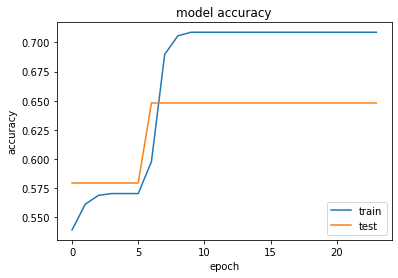

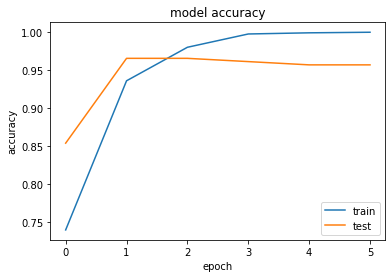

In [ ]:
target_names=['Claim','Premise']
 
y_pred=[]
y_true=[]

X_sg,X_Debater=X[:len(labels_list)], X[len(labels_list):]
X_sg_before,X_Debater_before=X_before[:len(labels_list)], X_before[len(labels_list):]
X_sg_after,X_Debater_after=X_after[:len(labels_list)], X_after[len(labels_list):]

X_train, X_test = X_Debater[Debater_sections_train_set], X_Debater[Debater_sections_test_set]
X_before_train, X_before_test = X_Debater_before[Debater_sections_train_set], X_Debater_before[Debater_sections_test_set]
X_after_train, X_after_test = X_Debater_after[Debater_sections_train_set], X_Debater_after[Debater_sections_test_set]
X_stat_train, X_stat_test = X_Debater_argument_sections_stat[Debater_sections_train_set], X_Debater_argument_sections_stat[Debater_sections_test_set]
Y_train, Y_test = Y_Debater[Debater_sections_train_set], Y_Debater[Debater_sections_test_set]

# Train the model.
model,model_stat=train_MultiModal(X_train, X_before_train,X_after_train,X_stat_train,Y_train)

# Transform probabilities predicted in the most probable value (0 or 1).
y_pred_temp=model.predict([X_test, X_before_test, X_after_test, X_stat_test]).tolist()
for input in y_pred_temp:
  y_pred.append(round(input[0]))
y_true+=Y_test.tolist()

In [ ]:
# Print the classification report of the result of the models created
print(classification_report(y_true, y_pred, target_names=target_names))   

              precision    recall  f1-score   support

       Claim       0.96      0.91      0.94       222
     Premise       0.94      0.97      0.95       292

    accuracy                           0.95       514
   macro avg       0.95      0.94      0.95       514
weighted avg       0.95      0.95      0.95       514



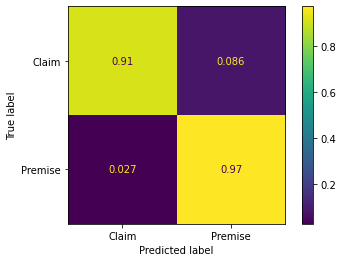

In [ ]:
# Print the confusion matrix.
cm=confusion_matrix(y_true, y_pred,normalize='true')

cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
cm_disp.plot()
plt.show()

## **Stat model results**

In [ ]:
y_pred=[]
y_true=[]

# Transform probabilities predicted in the most probable value (0 or 1).
y_pred_temp=model_stat.predict(X_stat_test).tolist()
for input in y_pred_temp:
  y_pred.append(round(input[0]))
y_true+=Y_test.tolist()

In [ ]:
# Print the classification report of the result of the models created
print(classification_report(y_true, y_pred, target_names=target_names)) 

              precision    recall  f1-score   support

       Claim       0.59      0.99      0.74       222
     Premise       0.99      0.47      0.64       292

    accuracy                           0.69       514
   macro avg       0.79      0.73      0.69       514
weighted avg       0.81      0.69      0.68       514



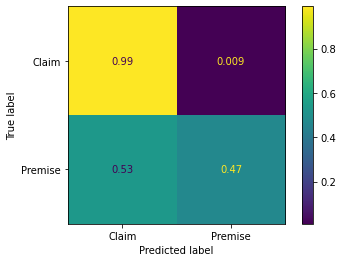

In [ ]:
# Print the confusion matrix.
cm=confusion_matrix(y_true, y_pred,normalize='true')

cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
cm_disp.plot()
plt.show()

# **Stab Gurevych Predictions**

In [ ]:
X_sg_train, X_sg_test = X_sg[sections_train_set], X_sg[sections_test_set]
X_sg_before_train, X_sg_before_test = X_sg_before[sections_train_set], X_sg_before[sections_test_set]
X_sg_after_train, X_sg_after_test = X_sg_after[sections_train_set], X_sg_after[sections_test_set]
X_sg_stat_train, X_sg_stat_test = X_argument_sections_stat[sections_train_set], X_argument_sections_stat[sections_test_set]
Y_sg_test = Y[sections_test_set]

In [ ]:
y_pred=[]
y_true=[]

# Transform probabilities predicted in the most probable value (0 or 1).
y_pred_temp=model.predict([X_sg_test, X_sg_before_test, X_sg_after_test, X_sg_stat_test]).tolist()
for input in y_pred_temp:
    y_pred.append(round(input[0]))
y_true+=Y_sg_test.tolist()

In [ ]:
# Print the classification report of the result of the models created
print(classification_report(y_true, y_pred, target_names=target_names))   

              precision    recall  f1-score   support

       Claim       0.41      0.95      0.58       330
     Premise       0.89      0.21      0.35       570

    accuracy                           0.49       900
   macro avg       0.65      0.58      0.46       900
weighted avg       0.72      0.49      0.43       900



## **Stab Gurevych Stat model results**

In [ ]:
y_pred=[]
y_true=[]

# Transform probabilities predicted in the most probable value (0 or 1).
y_pred_temp=model_stat.predict(X_sg_stat_test).tolist()
for input in y_pred_temp:
  y_pred.append(round(input[0]))
y_true+=Y_sg_test.tolist()

In [ ]:
# Print the classification report of the result of the models created
print(classification_report(y_true, y_pred, target_names=target_names)) 

              precision    recall  f1-score   support

       Claim       0.37      1.00      0.54       330
     Premise       0.50      0.00      0.00       570

    accuracy                           0.37       900
   macro avg       0.43      0.50      0.27       900
weighted avg       0.45      0.37      0.20       900



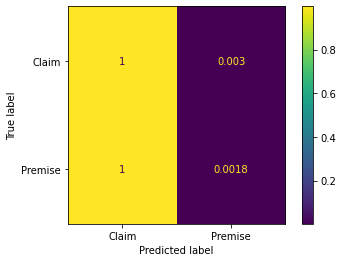

In [ ]:
# Print the confusion matrix.
cm=confusion_matrix(y_true, y_pred,normalize='true')

cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
cm_disp.plot()
plt.show()